In [76]:
# import numpy as np
import numpy as np
%pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2

from Functions import image_processing as ip
from Functions import seed_detection as sd
from Functions import seeded_region_growing as srg
from Functions import old_seeded_region_growing as old_srg
import skimage.io as sk
from Functions import region_merging as rm
from Functions import dice_score as ds

# from collections import Counter

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.0


C:\Users\ijung\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:50: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / (img[p] + 0.000001))


1000
2000
3000


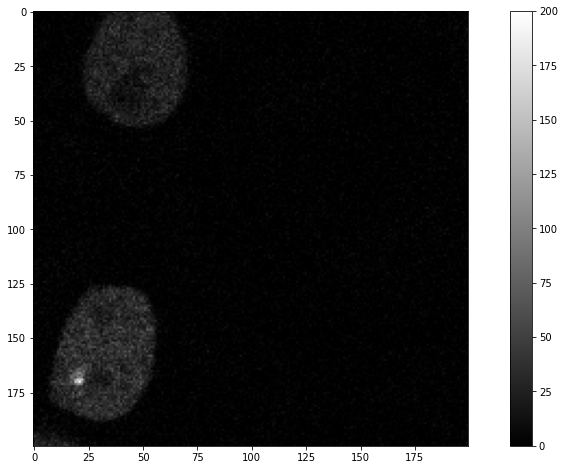

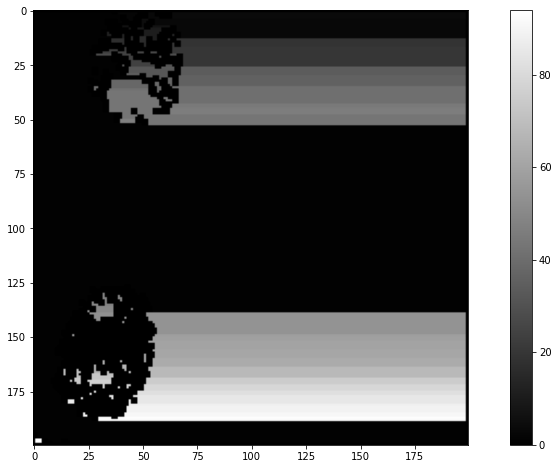

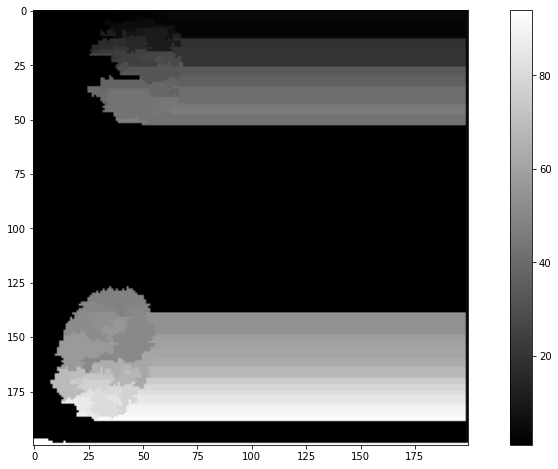

In [98]:
image_intensity = sk.imread("Data/N2DH-GOWT1/img/t31.tif")
image_intensity = image_intensity[300:500, 450:650]
#image_t = ip.image_clipping(image_intensity,0.15*np.amax(image_intensity),0.85*np.amax(image_intensity))
image_r = ip.image_clipping_extreme(image_intensity, 0.2*np.amax(image_intensity), 0.4*np.amax(image_intensity))
image_r = sd.seeds(image_r, 0.8)
image_r = sd.seed_merging(image_r)
#image_t = sd.seeds(image_t, 0.8)
#image_t = sd.seed_merging(image_t)
ip.show_image(image_intensity, 15, 8)
ip.show_image(image_r, 15, 8)
#ip.show_image(image_t, 15, 8)
image_srg = image_r.copy()
image_srg = srg.region_growing(image_intensity, image_r)
ip.show_image(image_srg, 15, 8)

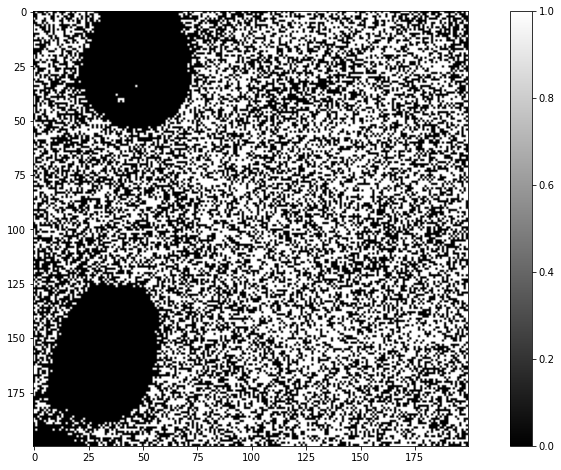

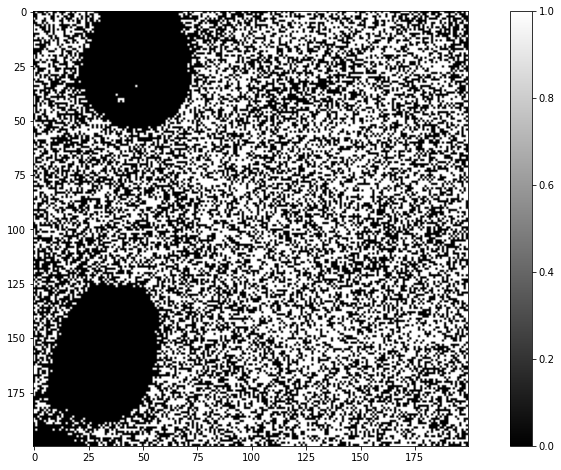

In [101]:
image_merged = image_srg.copy()
image_merged = rm.region_merging(image_intensity, image_srg, 0.05, 100)
ip.show_image(image_merged, 15, 8)
image_dice = ds.segmented_image_clip(image_merged, ds.find_background_number(image_merged))
ip.show_image(image_dice, 15, 8)

In [ ]:
image_intensity2 = sk.imread("Data/N2DH-GOWT1/img/t01.tif")
image_intensity2 = image_intensity2[300:500, 450:650]
image_r2 = ip.image_clipping_extreme(image_intensity2, 15, 50)
#image_r2 = sd.seeds(image_r2, 1)
#image_r2 = sd.seed_merging(image_r2)
ip.show_image(image_intensity2, 15, 8)
ip.show_image(image_r2, 15, 8)

In [ ]:
image_intensity3 = sk.imread("Data/N2DH-GOWT1/img/t21.tif")
image_intensity3 = image_intensity3[300:500, 450:650]
image_r3 = ip.image_clipping_extreme(image_intensity3, 15, 50)
#image_r3 = sd.seeds(image_r3, 1)
#image_r3 = sd.seed_merging(image_r3)
ip.show_image(image_intensity3, 15, 8)
ip.show_image(image_r3, 15, 8)
